In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

W1206 10:19:38.435710 140266919671616 __init__.py:329] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W1206 10:19:38.445597 140266919671616 __init__.py:329] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W1206 10:19:38.446630 140266919671616 __init__.py:329] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W1206 10:19:38.461788 140266919671616 __init__.py:357] Limited tf.summary API due to missing TensorBoard installation.


In [2]:
from tensorflow.keras import layers
from tensorflow import keras

## Prepare Dataset

In [3]:
from pathlib import Path
import cv2

In [4]:
# Get labels + filenames
chars = set()
labels = []
files = []
bad_samples = []
data_root_path = Path("../data2")
for line in open(data_root_path/"sentences.txt").read().splitlines():
    if line[0] == "#":
        continue
    tokens = line.split(" ")
    assert len(tokens) > 9
    # Get file names
    filename_token = tokens[0].split("-")
    file_path = data_root_path/f'{filename_token[0]}/{filename_token[0] + "-" + filename_token[1]}/{tokens[0]}.png'  
    if not os.path.getsize(file_path):
        bad_samples.append(file_path)
        continue
    label = " ".join(" ".join(tokens[9:]).split("|"))
    labels.append(label)
    chars = chars.union(set(list(label)))
    files.append(str(file_path))
    assert len(files) == len(labels)

In [5]:
def display_image(path, label):
    plt.title(label, fontsize=12)
    plt.imshow(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

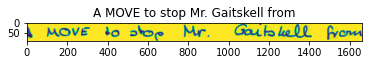

In [6]:
display_image(files[0], labels[0])

In [8]:
import random
def preprocess(img, imgSize, dataAugmentation=False):
    "put img into target img of size imgSize, transpose for TF and normalize gray-values"
    
    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = np.zeros([imgSize[1], imgSize[0]])
    
    # increase dataset size by applying random stretches to the images
    if dataAugmentation:
        stretch = (random.random() - 0.5) # -0.5 .. +0.5
        wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
        img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
    
    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize)
    target = np.ones([ht, wt]) * 255
    target[0:newSize[1], 0:newSize[0]] = img
    
    # transpose for TF
    img = target
    
    # normalize
    #(m, s) = cv2.meanStdDev(img)
    #m = m[0][0]
    #s = s[0][0]
    #img = img - m
    #img = img / s if s>0 else img
    img = img/255
    return img

## Process data for learning task

In [9]:
import math
length = math.floor(0.9*len(files))
idxs = np.arange(0, len(files))
rand_idxs = tf.random.shuffle(idxs, seed=42).numpy()
train_idxs = rand_idxs[:length]
test_idxs = rand_idxs[length:]

In [10]:
train_files = np.array([files[f] for f in train_idxs])
test_files = np.array([files[f] for f in test_idxs])

assert len(train_files) + len(test_files) == len(files)

In [11]:
train_files

array(['../data2/a01/a01-091/a01-091-s03-00.png',
       '../data2/c03/c03-016c/c03-016c-s01-02.png',
       '../data2/j04/j04-039/j04-039-s01-06.png', ...,
       '../data2/p03/p03-121/p03-121-s06-01.png',
       '../data2/h07/h07-020/h07-020-s00-01.png',
       '../data2/g07/g07-003b/g07-003b-s00-02.png'], dtype='<U41')

In [12]:
chars = sorted(chars)
char2idx = {u:i for i,u in enumerate(chars)}
idx2char = np.array(chars)

In [13]:
def encode_to_labels(txt):
    encoded = []
    for c in txt:
        encoded.append(char2idx[c])
    return encoded

In [14]:
max_text_length = 0

In [15]:
train_images = []
train_input_lengths = []
train_label_lengths = []
orig_txt = []
train_txt = []
for i in train_idxs:
    train_images.append(np.expand_dims(preprocess(cv2.imread(files[i], cv2.IMREAD_GRAYSCALE), imgSize=(512,32),dataAugmentation=True), axis=-1))
    train_input_lengths.append(127)
    train_label_lengths.append(len(labels[i]))
    if len(labels[i]) > max_text_length: max_text_length = len(labels[i])
    train_txt.append(encode_to_labels(labels[i]))
    orig_txt.append(labels[i])

In [16]:
test_images = []
test_input_lengths = []
test_label_lengths = []
test_txt = []
test_orig_txt = []
for i in test_idxs:
    test_images.append(np.expand_dims(preprocess(cv2.imread(files[i], cv2.IMREAD_GRAYSCALE), imgSize=(512,32)), axis=-1))
    test_input_lengths.append(127)
    test_label_lengths.append(len(labels[i]))
    if len(labels[i]) > max_text_length: max_text_length = len(labels[i])
    test_txt.append(encode_to_labels(labels[i]))
    test_orig_txt.append(labels[i])

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
train_padded_txt = pad_sequences(train_txt, maxlen=max_text_length, padding='post', value=len(chars))

In [19]:
test_padded_txt = pad_sequences(test_txt, maxlen=max_text_length, padding='post', value=len(chars))

In [73]:
chars

[' ',
 '!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

## Model

In [52]:
inputs = layers.Input(shape=(32, 512, 1))
conv_1 = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='conv1')(inputs)
pool_1 = layers.MaxPool2D(pool_size=(2,2), name='pool1')(conv_1)
conv_2 = layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='conv2')(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2,2), name='pool2')(conv_2)
conv_3 = layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='conv3')(pool_2)
batch_1 = layers.BatchNormalization(name='batch1')(conv_3)
conv_4 = layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='conv4')(batch_1)
pool_3 = layers.MaxPool2D(pool_size=(2,1), name='pool3')(conv_4)
conv_5 = layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='conv5')(pool_3)
batch_2 = layers.BatchNormalization(name='batch2')(conv_5)
conv_6 = layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='conv6')(batch_2)
pool_4 = layers.MaxPool2D(pool_size=(2,1), name='pool4')(conv_6)
conv_7 = layers.Conv2D(filters=512, kernel_size=(2,2), strides=(1,1), padding='valid', activation='relu', name='conv7')(pool_4)
squeezed = layers.Lambda(lambda x: tf.squeeze(x, axis=1))(conv_7)
blstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True), name='blstm_1')(squeezed)
blstm_2 = layers.Bidirectional(layers.LSTM(128, return_sequences=True), name='blstm_2')(blstm_1)
outputs = layers.Dense(80, activation = 'softmax')(blstm_2)

In [21]:
act_model = tf.keras.Model(inputs, outputs)

In [22]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 512, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 512, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 256, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 256, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 128, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 128, 256)       295168    
_________________________________________________________________
batch1 (BatchNormalization)  (None, 8, 128, 256)       1024  

In [23]:
labels = layers.Input(name='the_labels', shape=[max_text_length], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])
model = tf.keras.Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 512, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 512, 64)  640         input_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 16, 256, 64)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 16, 256, 128) 73856       pool1[0][0]                      
____________________________________________________________________________________________

In [71]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [26]:
training_img = np.array(train_images)
train_input_length = np.array(train_input_lengths)
train_label_length = np.array(train_label_lengths)

valid_img = np.array(test_images)
valid_input_length = np.array(test_input_lengths)
valid_label_length = np.array(test_label_lengths)

In [69]:
filepath="best_model_2.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [70]:
model.fit(x=[training_img[:5000], train_padded_txt[:5000], train_input_length[:5000], train_label_length[:5000]], y=np.zeros(len(training_img[:5000])), batch_size=256, epochs = 100, validation_data = ([valid_img[:100], test_padded_txt[:100], valid_input_length[:100], valid_label_length[:100]], [np.zeros(len(valid_img[:100]))]), verbose = 1, callbacks = callbacks_list)

W1206 11:12:37.007085 140266919671616 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f901d42dcb0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - ETA: 0s - loss: 778.4041

W1206 11:13:14.621090 140266919671616 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f901d491a70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 00001: val_loss improved from inf to 793.94135, saving model to best_model_2.hdf5
20/20 [==============================] - 32s 2s/step - loss: 778.4041 - val_loss: 793.9413
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 778.4041
Epoch 00002: val_loss did not improve from 793.94135
20/20 [==============================] - 31s 2s/step - loss: 778.4041 - val_loss: 793.9413
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 778.4039
Epoch 00003: val_loss did not improve from 793.94135
20/20 [==============================] - 31s 2s/step - loss: 778.4039 - val_loss: 793.9413
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 7

KeyboardInterrupt: 

array([66, 67, 72,  0, 62, 67, 61, 66,  0, 77, 67, 73,  0, 12,  0,  5, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79], dtype=int32)

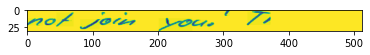

In [61]:
plt.imshow(np.squeeze(training_img[4999]))
train_padded_txt[4999]

In [38]:
train_padded_txt[0].shape

(93,)

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 512, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 512, 64)  640         input_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 16, 256, 64)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 16, 256, 128) 73856       pool1[0][0]                      
____________________________________________________________________________________________

In [41]:
lbs = labels

In [36]:
valid_img = np.array(test_images)
valid_input_length = np.array(test_input_lengths)
valid_label_length = np.array(test_label_lengths)

In [38]:
valid_img.shape

(1676, 32, 512, 1)

In [ ]:
model(valid_img)

In [28]:
act_model.load_weights("best_model.hdf5")

In [56]:
prediction = act_model.predict(training_img[:20])

In [71]:
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        print(out_best)
        out_best = [k for k, g in itertools.groupby(out_best)]
        print(out_best)
        outstr = "" if out_best[0] == 79 else idx2char[out_best]
        ret.append(outstr)
    return ret

In [58]:
import itertools
decode_batch(prediction)

[79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79]
[79]
[79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 7

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [48]:
valid_img.shape

(1676, 32, 512, 1)

In [64]:
prediction[0][0]

1.0

In [51]:
out = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True))

In [54]:
prediction.shape

(10, 127, 80)

In [52]:
out

([<tf.Tensor: shape=(10, 0), dtype=int64, numpy=array([], shape=(10, 0), dtype=int64)>],
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[54.974827],
        [54.975483],
        [54.90303 ],
        [55.049744],
        [55.02597 ],
        [54.894756],
        [55.027332],
        [54.999607],
        [54.990856],
        [54.898495]], dtype=float32)>)

In [100]:
np.argmax(prediction[0][0])

79

In [ ]:
model.predict(valid_img)

In [91]:
new_prediction = tf.transpose(prediction, perm=(1, 0, 2))